<a href="https://colab.research.google.com/github/sgulyano/mat202/blob/main/lab2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MAT-202 Lab 2: ARIMA Forecasting

CMKL University

By Sarun Gulyanon


### Goal

learn how to apply ARIMA (Autoregressive Integrated Moving Average) models for time series forecasting.

### Outline

In this lab, we will:
1. Explore a real-world time series dataset  
2. Test for stationarity (ADF test) and apply differencing  
3. Analyze ACF and PACF plots to select ARIMA parameters  
4. Build and fit ARIMA models using Python (`statsmodels`)  
5. Forecast future values and compare against actual data  
6. Evaluate model accuracy and interpret results

----

# 1. Data Collection

For this lab, we will use the [Gold Future Prices dataset](https://www.kaggle.com/datasets/gvyshnya/gold-future-prices/) from Kaggle.  
The dataset contains historical gold futures market data, including the *Close* price, which we will use for forecasting.

In [3]:
#!/bin/bash
!curl -L -o ./gold-future-prices.zip\
  https://www.kaggle.com/api/v1/datasets/download/gvyshnya/gold-future-prices
!unzip gold-future-prices.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100 50847  100 50847    0     0   110k      0 --:--:-- --:--:-- --:--:--  110k


In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error

In [5]:
# Define the path to your CSV file
csv_path = "future-gc00-daily-prices.csv"
# Read the CSV, parse 'Date' column as datetime, and set it as the index
data = pd.read_csv(csv_path, parse_dates=["Date"], dayfirst=False, index_col="Date")
# Sort the DataFrame by the Date index in ascending order
data.sort_index(inplace=True)

In [7]:
data.head()

,Open,High,Low,Close
Date,,,,
2009-04-24,905.50,915.40,904.20,914.10
2009-04-27,915.00,919.70,905.80,908.20
2009-04-28,907.20,907.70,884.60,893.60
2009-04-29,894.00,904.00,888.30,900.50
2009-04-30,898.60,900.80,880.10,891.20


# 2. Data Preprocessing

Before building the ARIMA model, we need to clean and prepare the dataset:  
- Convert the *Close* price column into numeric values  
- Handle missing values or invalid entries  
- Ensure the data is indexed by *Date* for proper time series analysis

This step ensures the dataset is ready for stationarity testing, model fitting, and forecasting.

In [10]:
# Clean the "Close" column
data["Close"] = data["Close"].replace(',', '', regex=True)
data["Close"] = pd.to_numeric(data["Close"], errors='coerce')
data["Close"] = data["Close"].replace([np.inf, -np.inf], np.nan)
data.dropna(subset=["Close"], inplace=True)

In [14]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3724 entries, 2009-04-24 to 2024-02-08
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Open    3724 non-null   object 
 1   High    3724 non-null   object 
 2   Low     3724 non-null   object 
 3   Close   3724 non-null   float64
dtypes: float64(1), object(3)
memory usage: 145.5+ KB


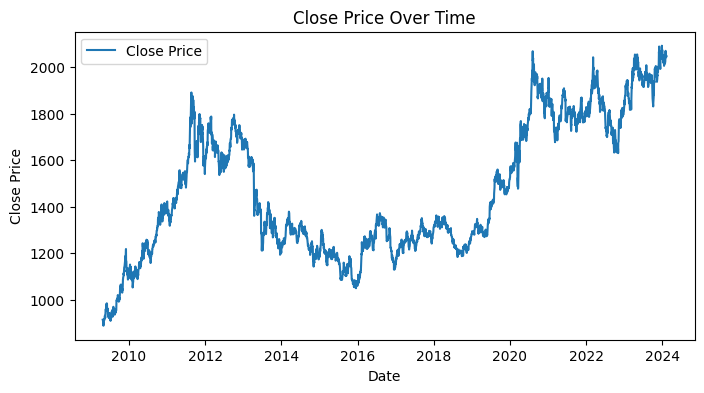

In [13]:
# Plotting the original Close price
plt.figure(figsize=(8, 4))
plt.plot(data.index, data["Close"], label='Close Price')
plt.title('Close Price Over Time')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.show()

An ARIMA model requires the input time series to be *stationary* (constant mean and variance over time). To verify this, we will apply the *Augmented Dickey–Fuller (ADF) test* to check for stationarity. We will see that applying *differencing* help transform the data into a stationary form.

In [16]:
# Perform the Augmented Dickey-Fuller (ADF) test on the original series
result_original = adfuller(data["Close"])
print(f"ADF Statistic (Original): {result_original[0]:.4f}")
print(f"p-value (Original): {result_original[1]:.4f}")

if result_original[1] < 0.05:
    print("Interpretation: The original series is Stationary.\n")
else:
    print("Interpretation: The original series is Non-Stationary.\n")

# Apply first-order differencing
data['Close_Diff'] = data['Close'].diff()

# Perform the Augmented Dickey-Fuller (ADF) test on the differenced series
result_diff = adfuller(data["Close_Diff"].dropna())
print(f"ADF Statistic (Differenced): {result_diff[0]:.4f}")
print(f"p-value (Differenced): {result_diff[1]:.4f}")

if result_diff[1] < 0.05:
    print("Interpretation: The differenced series is Stationary.")
else:
    print("Interpretation: The differenced series is Non-Stationary.")


ADF Statistic (Original): -1.4367
p-value (Original): 0.5646
Interpretation: The original series is Non-Stationary.

ADF Statistic (Differenced): -19.1308
p-value (Differenced): 0.0000
Interpretation: The differenced series is Stationary.


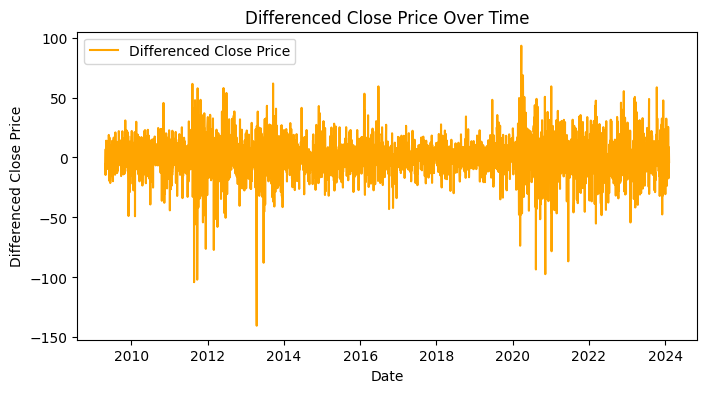

In [18]:
# Plotting the differenced Close price
plt.figure(figsize=(8, 4))
plt.plot(data.index, data['Close_Diff'], label='Differenced Close Price', color='orange')
plt.title('Differenced Close Price Over Time')
plt.xlabel('Date')
plt.ylabel('Differenced Close Price')
plt.legend()
plt.show()

Once the series is stationary, the next step is to identify suitable ARIMA parameters.

We use two tools for this:

- **Autocorrelation Function (ACF):** Helps identify the order of the Moving Average (MA, q) component.  
- **Partial Autocorrelation Function (PACF):** Helps identify the order of the Autoregressive (AR, p) component.  

By examining the ACF and PACF plots of the differenced series, we can propose initial values of `(p, d, q)` to use in the ARIMA model.

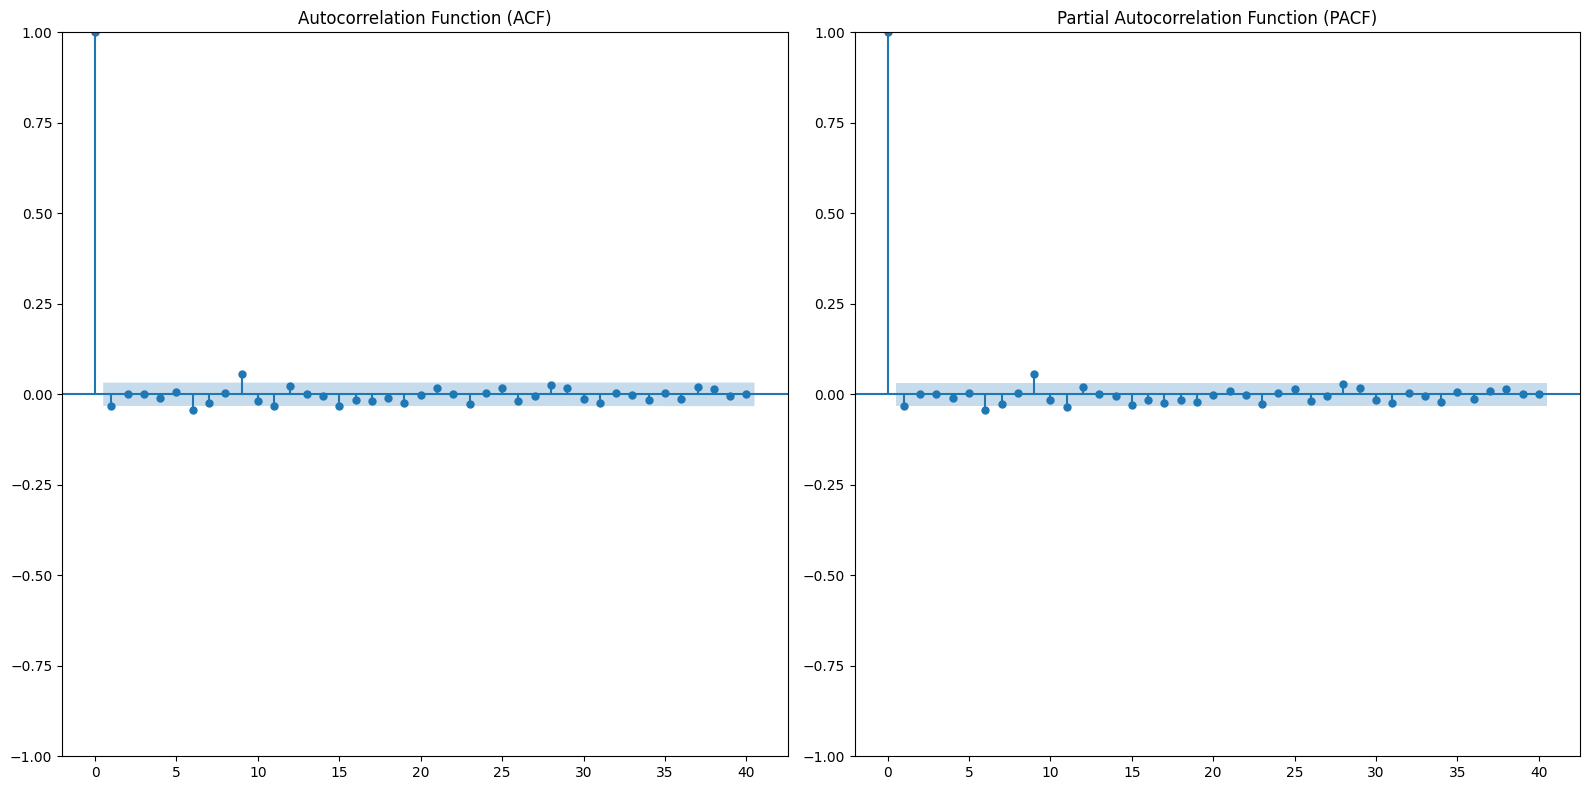

In [20]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt

# Plot ACF and PACF for the differenced series
fig, axes = plt.subplots(1, 2, figsize=(16, 8))

# ACF plot
plot_acf(data['Close_Diff'].dropna(), lags=40, ax=axes[0])
axes[0].set_title('Autocorrelation Function (ACF)')

# PACF plot
plot_pacf(data['Close_Diff'].dropna(), lags=40, ax=axes[1])
axes[1].set_title('Partial Autocorrelation Function (PACF)')

plt.tight_layout()
plt.show()


# 3. Forecasting

In this step, we will:
1. Split the dataset into **training** and **testing** sets.  
2. Fit the ARIMA model on the training data.  
3. Forecast the values for the testing period.  
4. Plot the predicted values against the actual data.  
5. Evaluate forecast performance.

In [ ]:
# Split data into train and test
train_size = int(len(data) * 0.8)
train, test = data.iloc[:train_size], data.iloc[train_size:]

# Fit ARIMA model
model = ARIMA(train["Close"], order=(40, 1, 40))
model_fit = model.fit()

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [ ]:
# Forecast
forecast = model_fit.forecast(steps=len(test))

# Plot the results with specified colors
plt.figure(figsize=(8, 4))
plt.plot(train.index, train["Close"], label='Train', color='#203147')
plt.plot(test.index, test["Close"], label='Test', color='#01ef63')
plt.plot(test.index, forecast, label='Forecast', color='orange')
plt.title('Close Price Forecast')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.show()

In [37]:
print(f"AIC: {model_fit.aic}")
print(f"BIC: {model_fit.bic}")

AIC: 24599.538387593613
BIC: 24641.53143808632


In [38]:
forecast = forecast[:len(test)]
test_close = test["Close"][:len(forecast)]
# Calculate RMSE
rmse = np.sqrt(mean_squared_error(test_close, forecast))
print(f"RMSE: {rmse:.4f}")

RMSE: 119.0186


---